# import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import warnings

sns.set_theme(style="whitegrid")
warnings.filterwarnings("ignore")

# import dataset

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/Sebercheres/UTS-DL/main/dataset/creditcard.csv")

In [3]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,0
4,NaN,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,0


## splitting dataset

> before we do preprocessing we need to split the dataset into 80% for trainging, 10% for validation, and 10% for testing set

In [4]:
X = df.drop('Class', axis=1)
y = df['Class']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

# dealing with skewed data

> now that we have done splitting the first thing in the agenda is to deal with the skewed data.

In [6]:
X_train = X_train.applymap(np.cbrt)
X_val = X_val.applymap(np.cbrt)
X_test = X_test.applymap(np.cbrt)

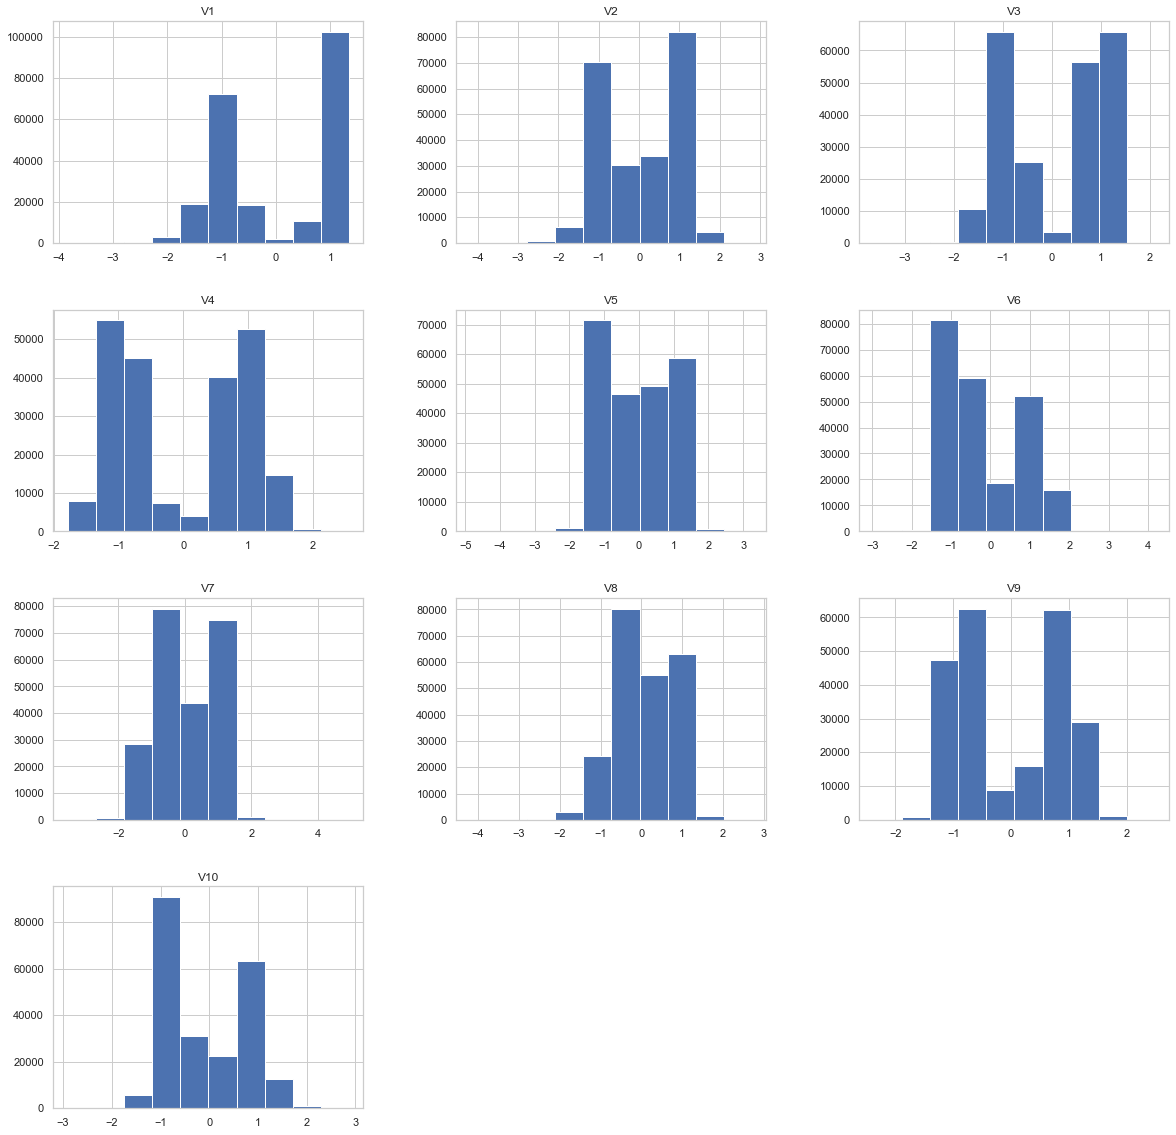

In [7]:
X_train.hist(figsize=(20,20))
plt.show()

> we can see that the skewness of the data has been dealt with

# dealing with nan values

> as i already said the nan values isn't that much so i will just impute it with its median.

In [8]:
impute = SimpleImputer(missing_values=np.nan, strategy='median')

In [9]:
X_train = impute.fit_transform(X_train)
X_val = impute.transform(X_val)
X_test = impute.transform(X_test)

> i want the all the set still to be a pandas dataframe so it will be easy to deal with it in outliar handling section

In [10]:
X_train = pd.DataFrame(X_train, columns=df.columns[:-1])
X_val = pd.DataFrame(X_val, columns=df.columns[:-1])
X_test = pd.DataFrame(X_test, columns=df.columns[:-1])

# dealing with outliar

> as i already mentioned im going to replace them with the max or min of the boxplot values based on their target class

In [11]:
def notMaxOutliar(x):
  iqr = x.quantile(0.75) - x.quantile(0.25)
  return x.loc[~((x > x.quantile(0.75) + 1.5 * iqr))].max()

def notMinOutliar(x):
  iqr = x.quantile(0.75) - x.quantile(0.25)
  return x.loc[~((x < x.quantile(0.25) - 1.5 * iqr))].min()

def rightOutliar(x):
  iqr = x.quantile(0.75) - x.quantile(0.25)
  return ((x > x.quantile(0.75) + 1.5 * iqr))

def leftOutliar(x):
  iqr = x.quantile(0.75) - x.quantile(0.25)
  return ((x < x.quantile(0.75) - 1.5 * iqr))

In [12]:
for col in df.columns[:-1]:
  maxOutliar = notMaxOutliar(X_train[col])
  minOutliar = notMinOutliar(X_train[col])
  
  X_train.loc[rightOutliar(X_train[col]), col] = maxOutliar
  X_val.loc[rightOutliar(X_val[col]), col] = maxOutliar
  X_test.loc[rightOutliar(X_test[col]), col] = maxOutliar
  
  X_train.loc[leftOutliar(X_train[col]), col] = minOutliar
  X_val.loc[leftOutliar(X_val[col]), col] = minOutliar
  X_test.loc[leftOutliar(X_test[col]), col] = minOutliar

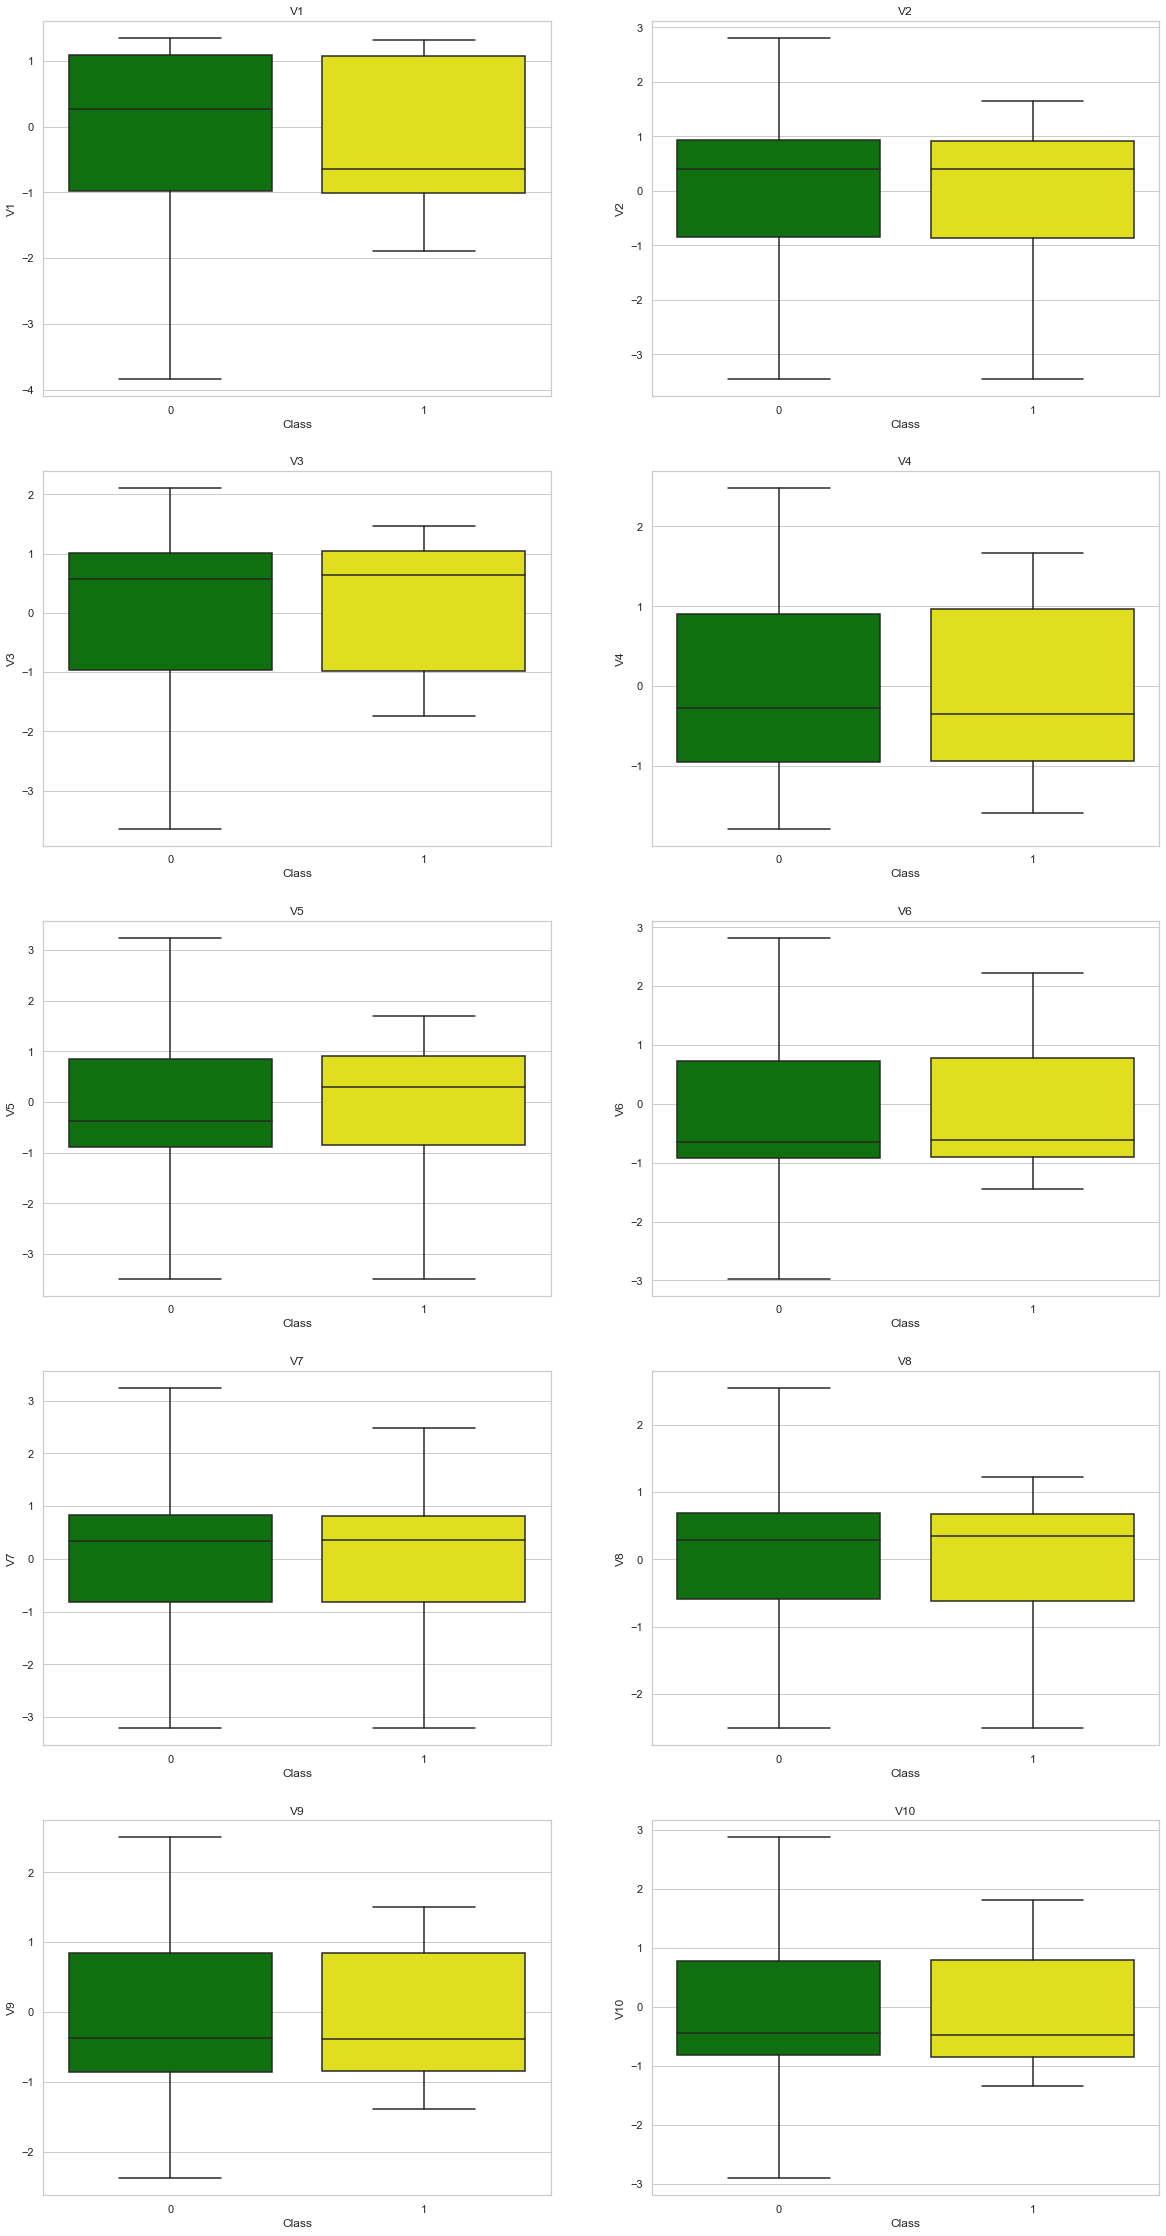

In [13]:
cols = df.columns[:-1]
colors = ['green','yellow']
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20,40))
idx = 0
for i in range(5):
    for j in range(2):
        loc = (i*2)+j
        sns.boxplot(x=y_train, y=cols[loc], data=X_train[X_train[cols[loc]]!=0], palette=colors, ax=axes[i][j])
        axes[i][j].set_title(cols[loc])


plt.show()

> as we can see we have succesfully dealing with the outliar

# dealing with imbalance

> now what im going to do is oversample it to only 20000 data with the class of 1

In [14]:
y_train.value_counts()

0    227451
1       394
Name: Class, dtype: int64

In [15]:
X_train.index = y_train.index
X_train['target'] = y_train
target0 = X_train.loc[X_train['target']==0][:20000]
target1 = X_train.loc[X_train['target']==1]
X_train.drop(X_train.loc[X_train['target']==0][:20000].index, inplace=True)
X_train.drop(X_train.loc[X_train['target']==1].index, inplace=True)

In [16]:
imbal = pd.concat([target0, target1])
imbal.target.value_counts()

0    20000
1      394
Name: target, dtype: int64

In [17]:
imbal_X = imbal.drop('target', axis=1)
imbal_y = imbal['target']
oversample = SMOTE()

imbal_X, imbal_y = oversample.fit_resample(imbal_X, imbal_y)

In [18]:
imbal_y.value_counts()

0    20000
1    20000
Name: target, dtype: int64

> now that we have oversample we need to append it to our X_train and shuffle it

In [19]:
imbal_X['target'] = imbal_y
X_train = pd.concat([X_train, imbal_X])
X_train = X_train.sample(frac=1).reset_index(drop=True)

In [20]:
y_train = X_train['target']
X_train = X_train.drop('target', axis=1)

# export all set

In [28]:
X_train.to_csv('./dataset/X_train.csv', index=False)
X_val.to_csv('./dataset/X_val.csv', index=False)
X_test.to_csv('./dataset/X_test.csv', index=False)

y_train.to_csv('./dataset/y_train.csv', index=False)
y_val.to_csv('./dataset/y_val.csv', index=False)
y_test.to_csv('./dataset/y_test.csv', index=False)

# conclusion

> now that we have done all the preprocessing all left to do is modelling